# Tutorial for using the Fitness Landscape Sequence Design Simulator

* [Building oracles for landscapes](#section-one)
* [Building a model of the landscape](#section-two)
* [Exploring a landscape with a model](#section-three)
* [Evaluating an exploration algorithm](#section-four)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## 1. Building oracles for landscapes <a class="anchor" id="section-one"></a>

In [5]:
import flexs

landscape = flexs.landscapes.RosettaFolding('../data/Protein_landscapes/folding_landscapes/3msi.pdb')

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.mac.python37.Release 2020.02+release.22ef835b4a2647af94fcd6421a85720f07eddf12 2020-01-05T17:31:56] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


You can now query the landscape for ground truth sequence fitnesses

In [8]:
wt = landscape.wt_pose.sequence()
print(wt)

landscape.get_fitness([wt])

MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVKGYAA


array([-3.48617905])

While we show this process on RNA landscapes there are other empirical landscapes that we have similar wrappers around. You can also make your own *custom* landscapes, but making RNA landcsapes with different targets, or a combination of targets (see the RNA_landscape_model_constructor for examples of how these can be made). 

## 2. Building a model of the landscape <a class="anchor" id="section-two"></a>

In reality, you don't have access to the ground truth landscape oracles except through costly experiments. Instead you can access an approximate version of it either by modeling the landscape through your current observations. In section 2.1 we use an abstract model to simulate the situation where you have a model with arbitrary noise. In section 2.2 we show some standard neural nets and use them as models of the landscape. It is easy to implement your own model. All they need to do is to implement `_fitness_function(sequence)` which gives you the model's estimate of a sequences fitness, and `update_model([sequence1, sequence2,...])` which will pay a cost to learn on the true labels of sequences.

### 2.1. Null model

The null model is the most simple model of the landscape. At each epoch, the model guesses the fitness of a variant by drawing a random sample from the exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = \mathbb{E}[f_\text{measured_sequences}]$. 

In [9]:
from flexs import baselines

null_model = baselines.models.NullModel()

We want to "measure" the true fitness of at least one sequence to start with (otherwise we can't have a model). We can do that by calling `measure_true_landscape` on the noisy model. This will charge you a "measurment cost", but in return tells you the true fitness of the sequence. When starting out or reusing the landscape, `reset` lets you zero the cost in the landscape, and if you pass it any sequences, it will measure those.  

let's ask it for the fitness of a random sequence (we will show more complex results later).

In [10]:
null_model.get_fitness([wt]), landscape.get_fitness([wt])

(array([0.00637576]), array([-3.48617905]))

### 2.2 Abstract model 

This is an abstract model that "emulates" a real model of the landscape. It works by guessing the fitness of a new sequence as a combination of it's real fitness and fitness of the closest known neighbor. 

To build a noisy model, you need to have an oracle, and a `signal_strength` $\alpha \in [0,1]$. This parameter $\alpha$ determines how much your oracle signal is corrupted by noise:

$f_{model}= \alpha^d f_{oracle} + (1-\alpha^d)\epsilon$

here $d$ is the distance to the closest measured neighbor, and $\epsilon$ is a sample from an exponential distribution $\lambda e^{-\lambda x}$, with $\lambda = f_\text{closest_neighbor}$ (for each queried sample, this is sampled once and then fixed for that batch). 

In [11]:
noisy_models = [baselines.models.NoisyAbstractModel(landscape, signal_strength=ss) for ss in [1, 0.9, 0.5, 0]]
for model in noisy_models:
    model.train([wt], landscape.get_fitness([wt]))

Let's measure the fitness of some samples through the model

In [22]:
import flexs.utils.sequence_utils as s_utils

val_x = np.array(list(set(s_utils.generate_random_mutant(wt, (i%10) / len(wt), alphabet=s_utils.AAS)
                  for i in range(1000))))
val_y = landscape.get_fitness(val_x)

noisy_preds = noisy_models[2].get_fitness(val_x[:5])
list(zip(val_x[:5], noisy_preds))

[('MAQASVVANQLIPINTHKTLVMMRWEVVQPVMDPAEDIPRLRSMQVDRAVPLGTTLMPDMVKGYAA',
  -3.5337371802949655),
 ('MAQASVVANQLIPIHQHLTLVMMRSEVVTPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVKGYAA',
  -3.7241302286137987),
 ('MAQASVVALQLPPIATHLTWVMMRSEVVTEVGTPDEDIPRLVSMQVQRAVPLGTTLMPDMVKGYAA',
  -3.503295691477148),
 ('MAQASVVANQLIPINTHPTLVMMRSEAVDPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVKGYAA',
  -3.7569677437920173),
 ('MAQASVVANQRIPINAHLTLVMMRSEVNTPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVPGYAL',
  -3.510678828482945)]

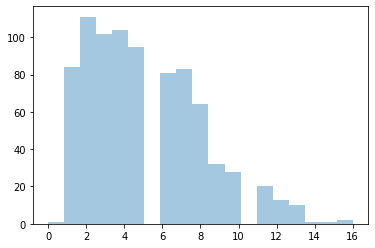

In [23]:
distances = [editdistance.eval(seq, wt) for seq in val_x]

sns.distplot(distances, kde=False)
plt.show()

In [24]:
import scipy.stats

def get_corr_per_distance(seqs, labels, preds):    
    corrs = []
    edit_distances = np.array([editdistance.eval(seq, wt) for seq in seqs])
    
    for dist in range(1,11):
        seqs_at_dist = edit_distances == dist
        
        if seqs_at_dist.sum() > 50:
            corrs.append(
                scipy.stats.pearsonr(labels[seqs_at_dist], preds[seqs_at_dist])[0]**2
            )
        else:
            corrs.append(np.nan)
            
    return corrs

In [25]:
corrs_noisy_neighbors = [get_corr_per_distance(val_x, val_y, noisy_model.get_fitness(val_x))
                         for noisy_model in noisy_models] 
corrs_null = get_corr_per_distance(val_x, val_y, null_model.get_fitness(val_x))

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


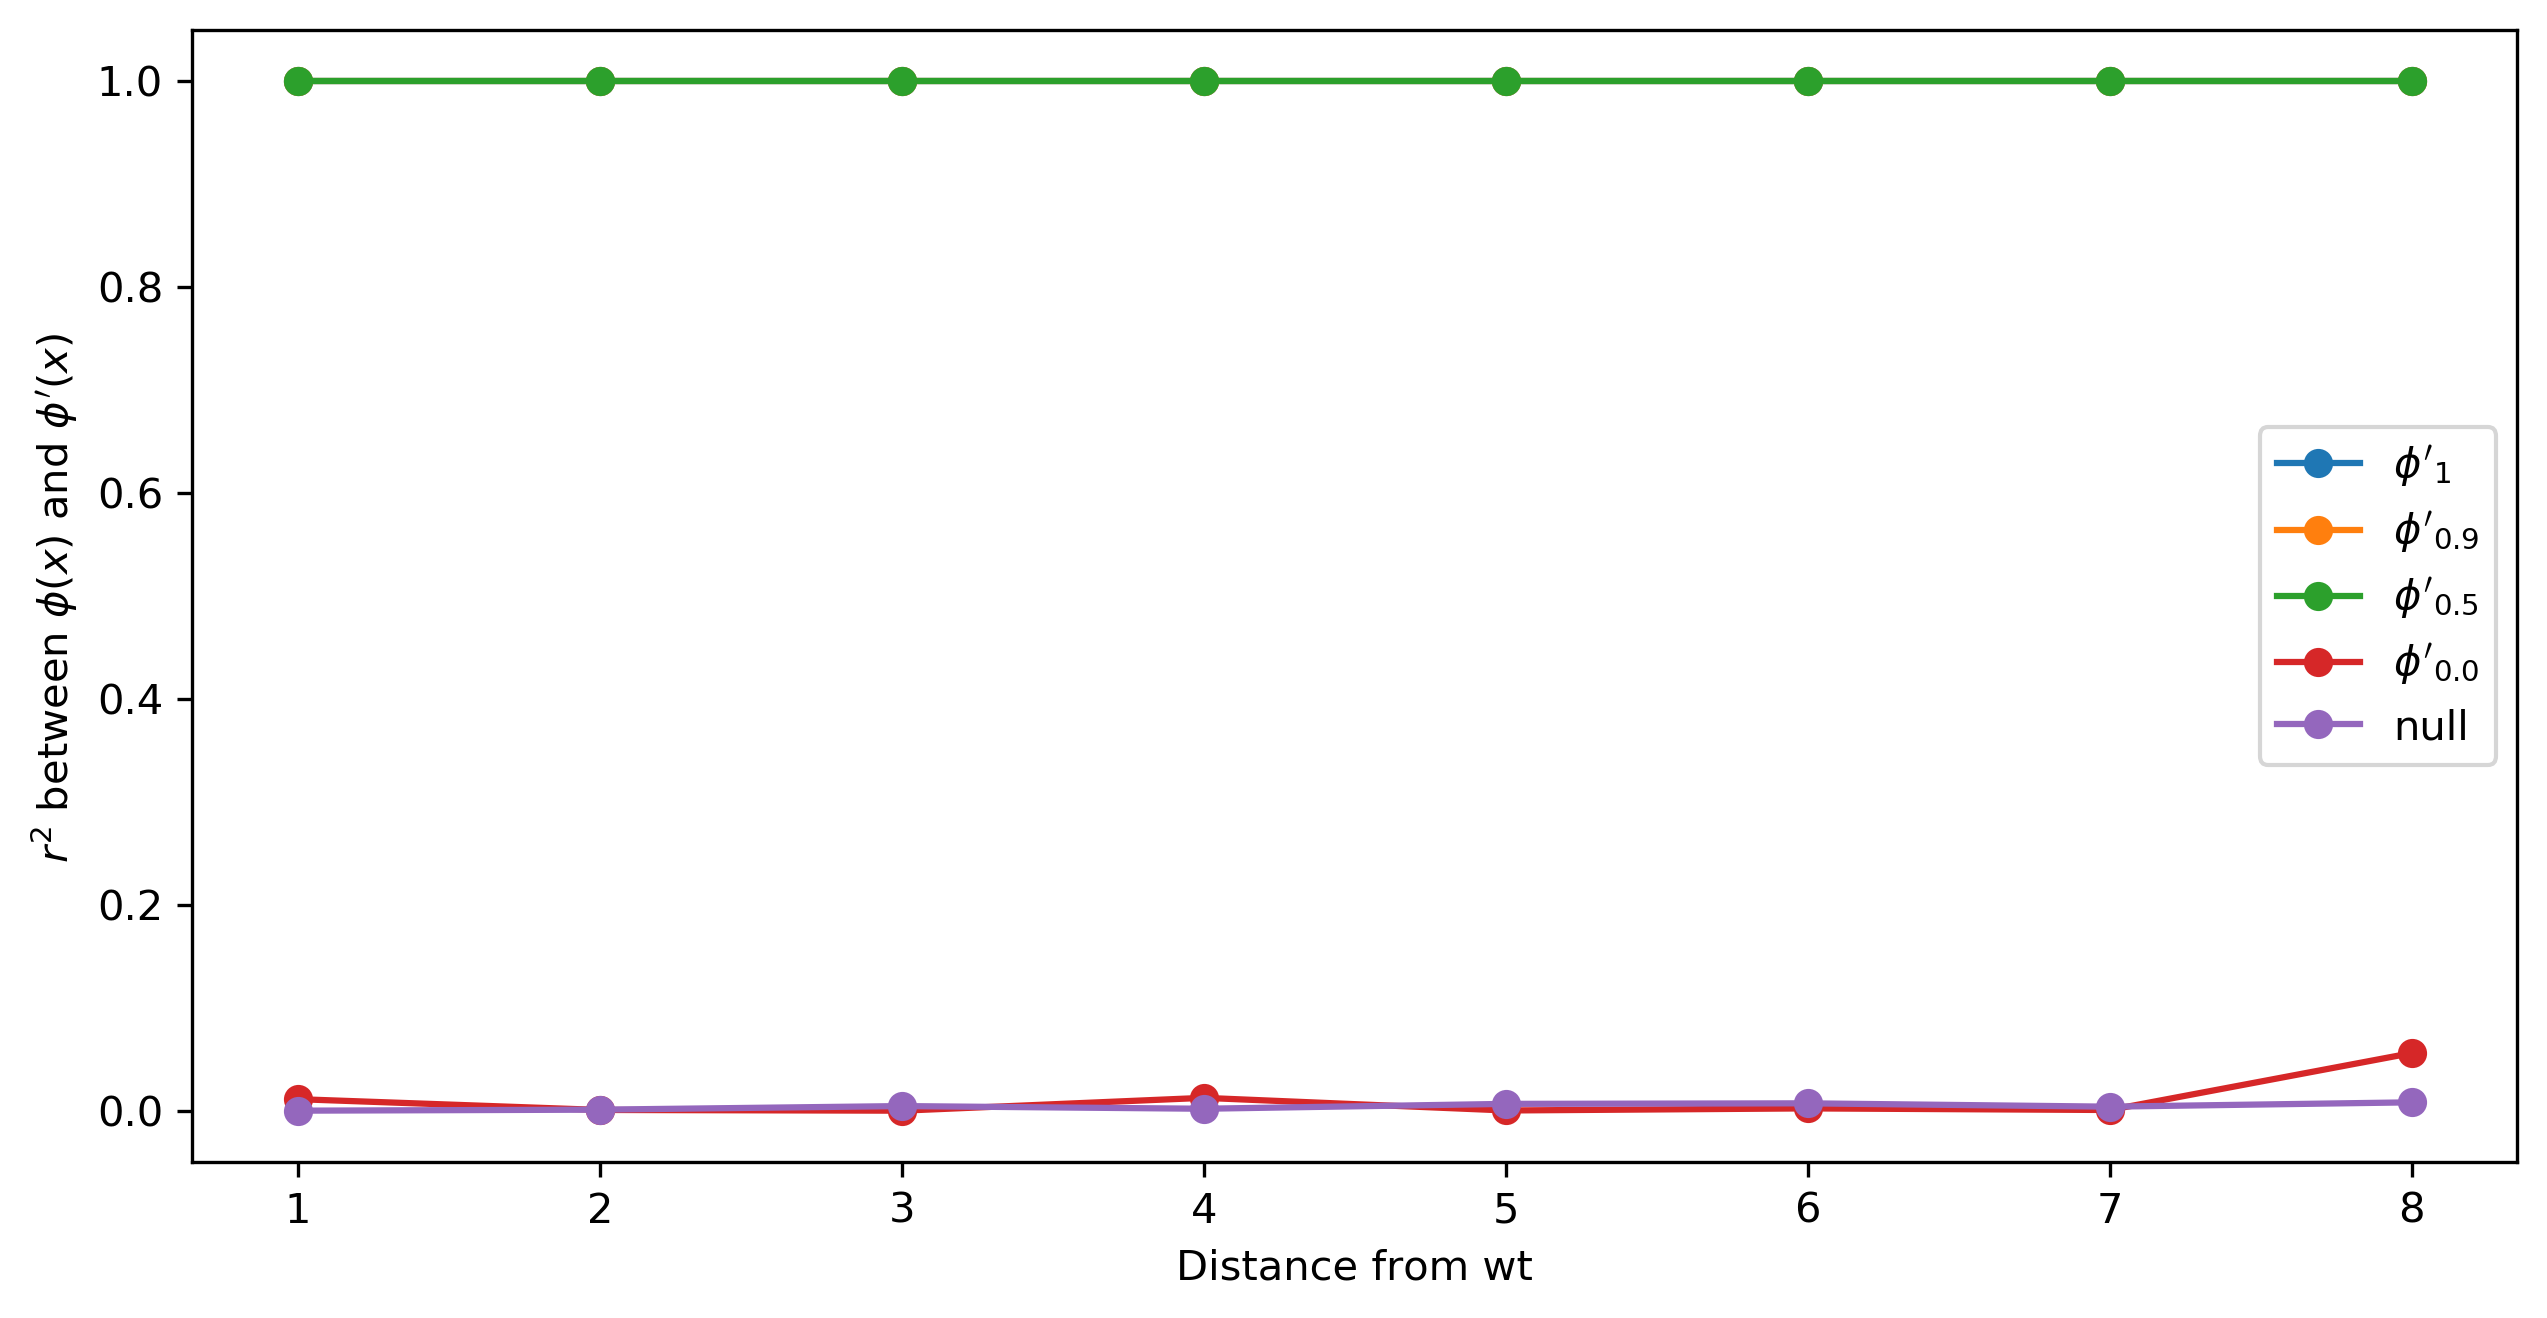

In [26]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(1,11), corrs_noisy_neighbors[0], 'o-', label="$\phi'_{1}$")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")
plt.plot(range(1,11), corrs_noisy_neighbors[2], 'o-', label="$\phi'_{0.5}$")
plt.plot(range(1,11), corrs_noisy_neighbors[3], 'o-', label="$\phi'_{0.0}$")
plt.plot(range(1,11), corrs_null, 'o-', label="null")
plt.ylabel("$r^2$ between $\phi(x)$ and $\phi'(x)$ ")
plt.xlabel("Distance from wt")
plt.legend()
plt.show()

In [27]:
ensemble = flexs.Ensemble(noisy_models)

ensemble.train([wt], landscape.get_fitness([wt]))

In [28]:
ensemble.get_fitness([wt])

array([-3.48617905])

In [29]:
ensemble.combine_with = lambda scores: scores
ensemble.get_fitness([wt])

array([[-3.48617905, -3.48617905, -3.48617905, -3.48617905]])

### 2.3 Models of landscapes built from data

Similarly, we can approximate the landscape by training a model on it. Some basic architectures are provided for convenience. 

For real models, it's more sensible to train them on more than just the WT

In [32]:
train_x = np.array(list(set([s_utils.generate_random_mutant(wt, (i%12) / len(wt), s_utils.AAS)
                                 for i in range(0, 10000)])))
train_y = landscape.get_fitness(train_x)
print (f'training data consisted of {len(train_x)} unique sequences')

training data consisted of 8425 unique sequences


In [33]:
linear_regression = baselines.models.LinearModel(alphabet=s_utils.AAS, loss='regression')
linear_regression.train(train_x, train_y)

linear_regression_preds = linear_regression.get_fitness(val_x)
corrs_linear = get_corr_per_distance(val_x, val_y, linear_regression_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(linear_regression_preds, val_y)[0]**2}")

Overall correlation: 0.9658969888312755


In [36]:
random_forest = baselines.models.RandomForest(alphabet=s_utils.AAS, loss='regression')
random_forest.train(train_x, train_y)

random_forest_preds = random_forest.get_fitness(val_x)
corrs_rf = get_corr_per_distance(val_x, val_y, random_forest_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(random_forest_preds, val_y)[0]**2}")

Overall correlation: 0.7095962311773616


In [37]:
sequence_length = len(train_x[0])

mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')
mlp.train(train_x, train_y)

mlp_preds = mlp.get_fitness(val_x)
corrs_mlp = get_corr_per_distance(val_x, val_y, mlp_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(mlp_preds, val_y)[0]**2}")

Overall correlation: 0.9706203615215905


In [39]:
cnn = baselines.models.CNN(sequence_length, alphabet=s_utils.AAS, num_filters=32, hidden_size=100, loss='MSE')
cnn.train(train_x, train_y)

cnn_preds = cnn.get_fitness(val_x)
corrs_cnn = get_corr_per_distance(val_x, val_y, cnn_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_preds, val_y)[0]**2}")

Overall correlation: 0.9267537416806317


We can easily ensemble these models of the landscape as well. 

In [42]:
cnn_ensemble = flexs.Ensemble([
    baselines.models.CNN(sequence_length, alphabet=s_utils.AAS, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ensemble.train(train_x, train_y)

cnn_ensemble_preds = cnn_ensemble.get_fitness(val_x)
corrs_cnn_ensemble = get_corr_per_distance(val_x, val_y, cnn_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ensemble_preds, val_y)[0]**2}")

Overall correlation: 0.9456760287122361


In [30]:
cnn_ada_ensemble = flexs.baselines.models.AdaptiveEnsemble([
    baselines.models.CNN(sequence_length, alphabet=s_utils.AAS, num_filters=32, hidden_size=100, loss='MSE')
    for i in range(3)
])
cnn_ada_ensemble.train(train_x, train_y)

cnn_ada_ensemble_preds = cnn_ada_ensemble.get_fitness(val_x)
corrs_cnn_ada_ensemble = get_corr_per_distance(val_x, val_y, cnn_ada_ensemble_preds)

print(f"Overall correlation: {scipy.stats.pearsonr(cnn_ada_ensemble_preds, val_y)[0]**2}")

Overall correlation: 0.8532962879384435


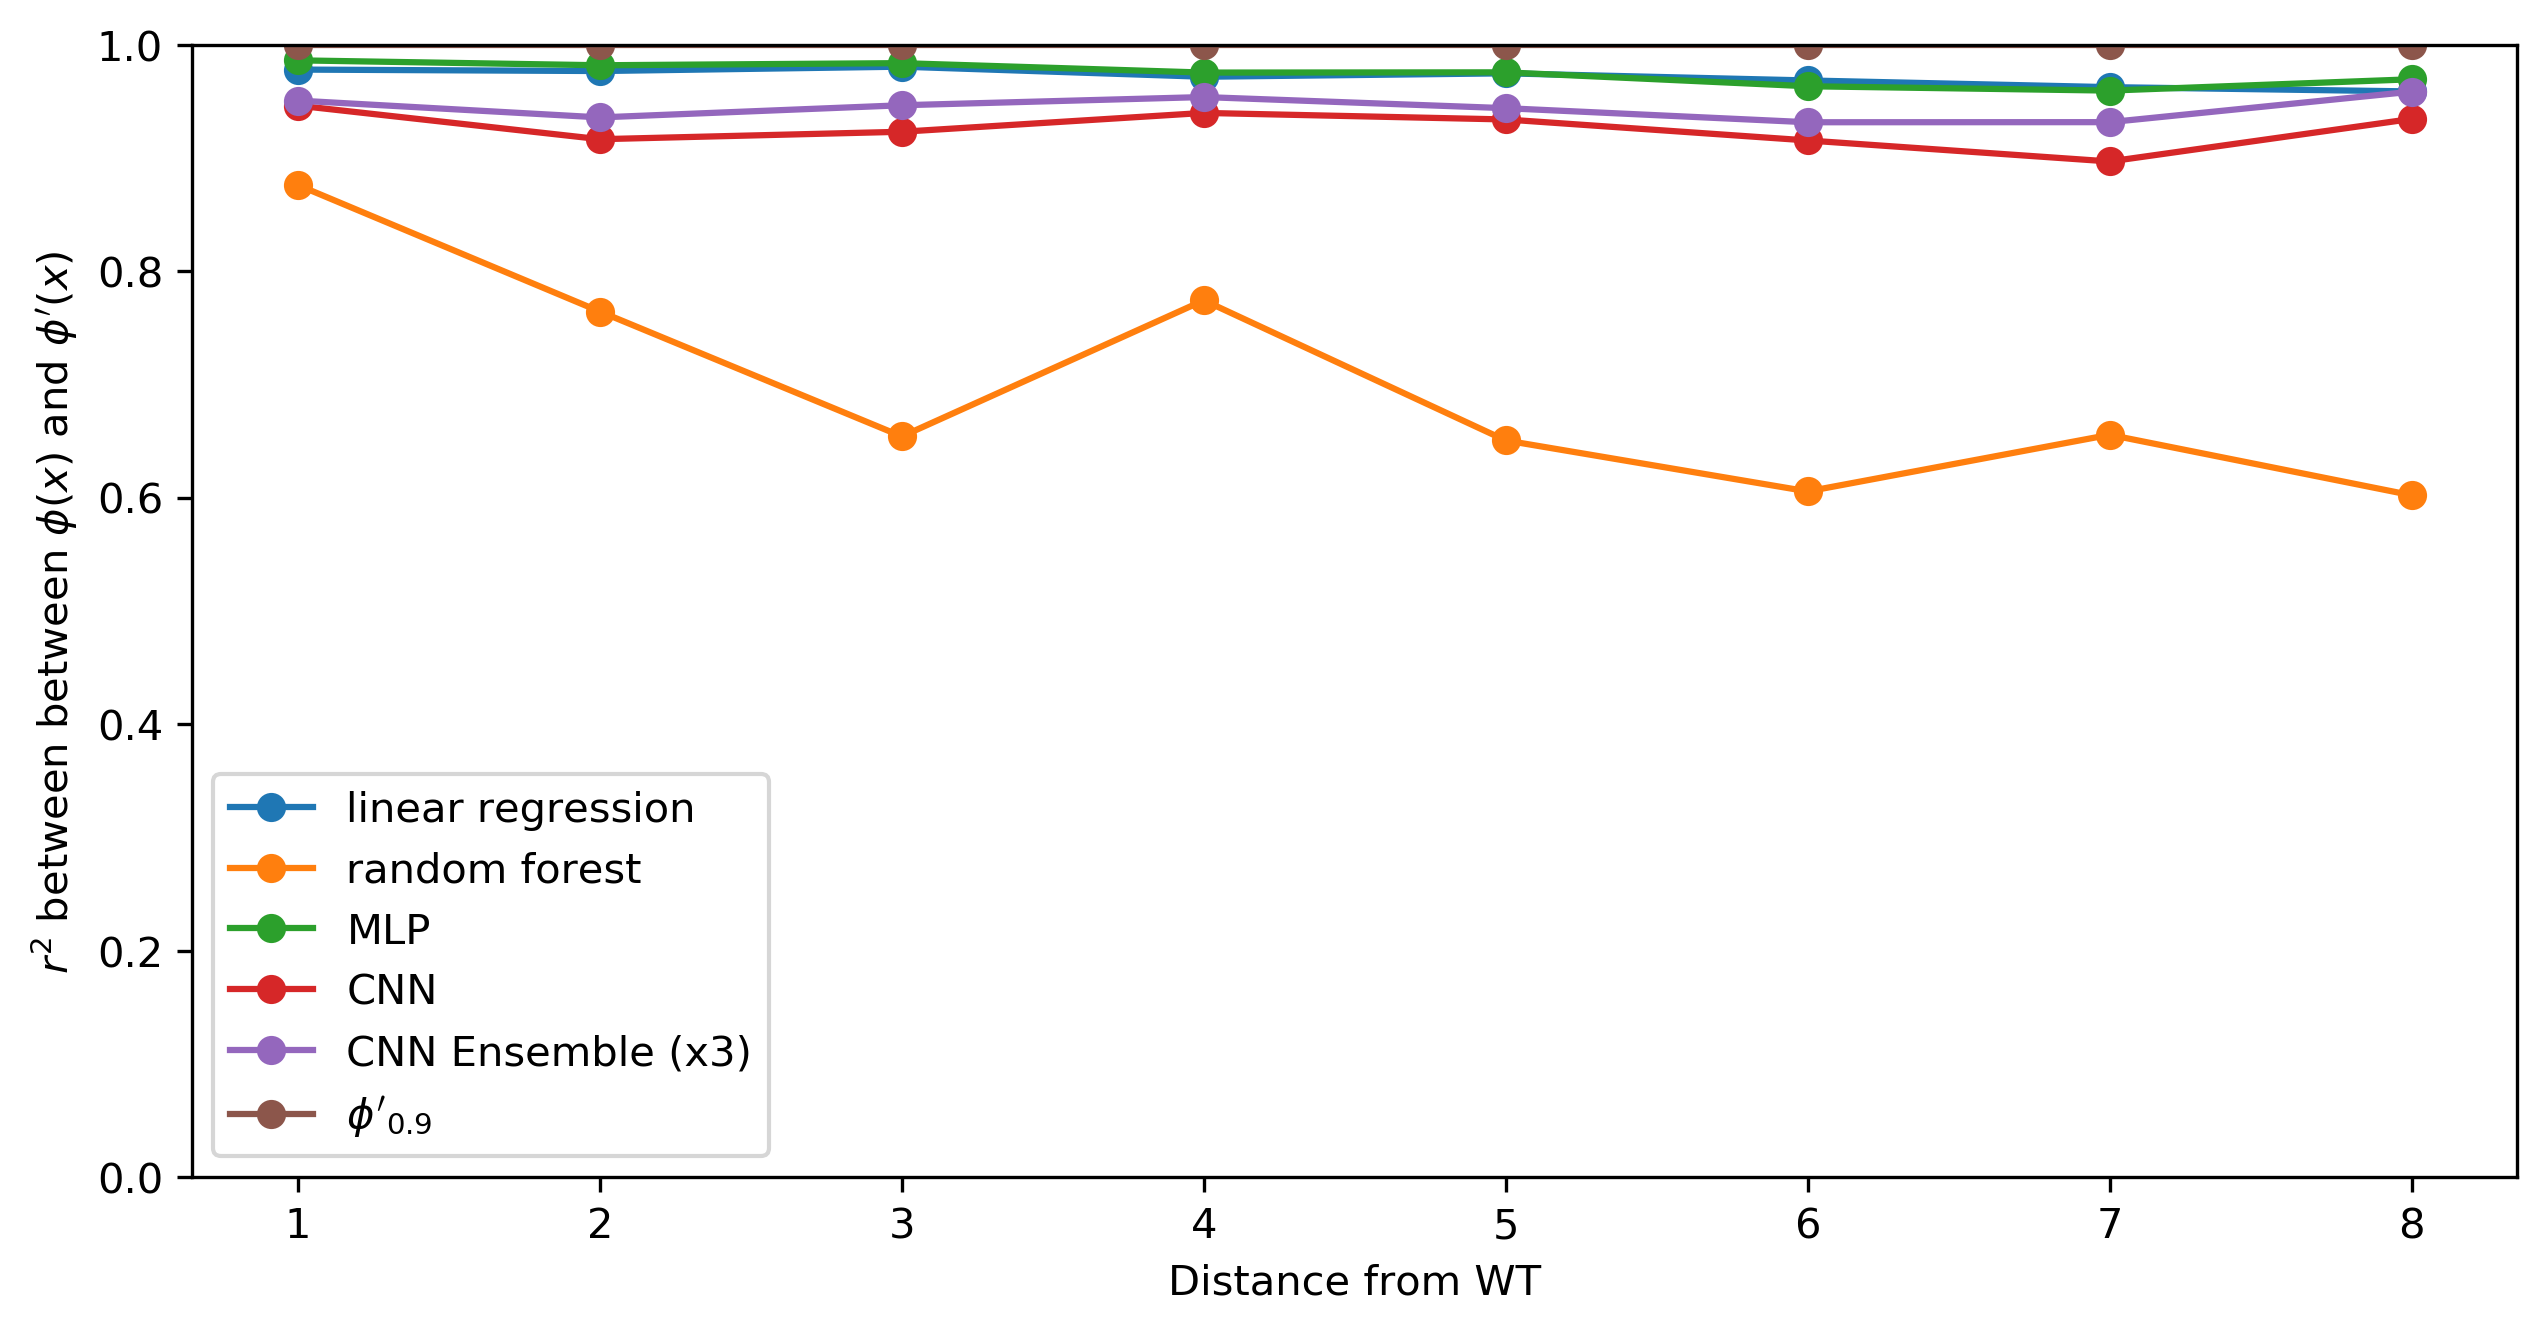

In [43]:
plt.figure(figsize=(10,5), dpi=300)

plt.plot(range(1,11), corrs_linear, 'o-', label="linear regression")
plt.plot(range(1,11), corrs_rf, 'o-', label="random forest")
plt.plot(range(1,11), corrs_mlp, 'o-', label="MLP")
plt.plot(range(1,11), corrs_cnn, 'o-', label="CNN")
plt.plot(range(1, 11), corrs_cnn_ensemble, 'o-', label="CNN Ensemble (x3)")
#plt.plot(range(1, 11), corrs_cnn_ada_ensemble, 'o-', label="Adaptive CNN Ensemble (x3)")
plt.plot(range(1,11), corrs_noisy_neighbors[1], 'o-', label="$\phi'_{0.9}$")

plt.ylabel("$r^2$ between between $\phi(x)$ and $\phi'(x)$")
plt.xlabel("Distance from WT")
plt.legend()
plt.ylim(0, 1)
plt.show()

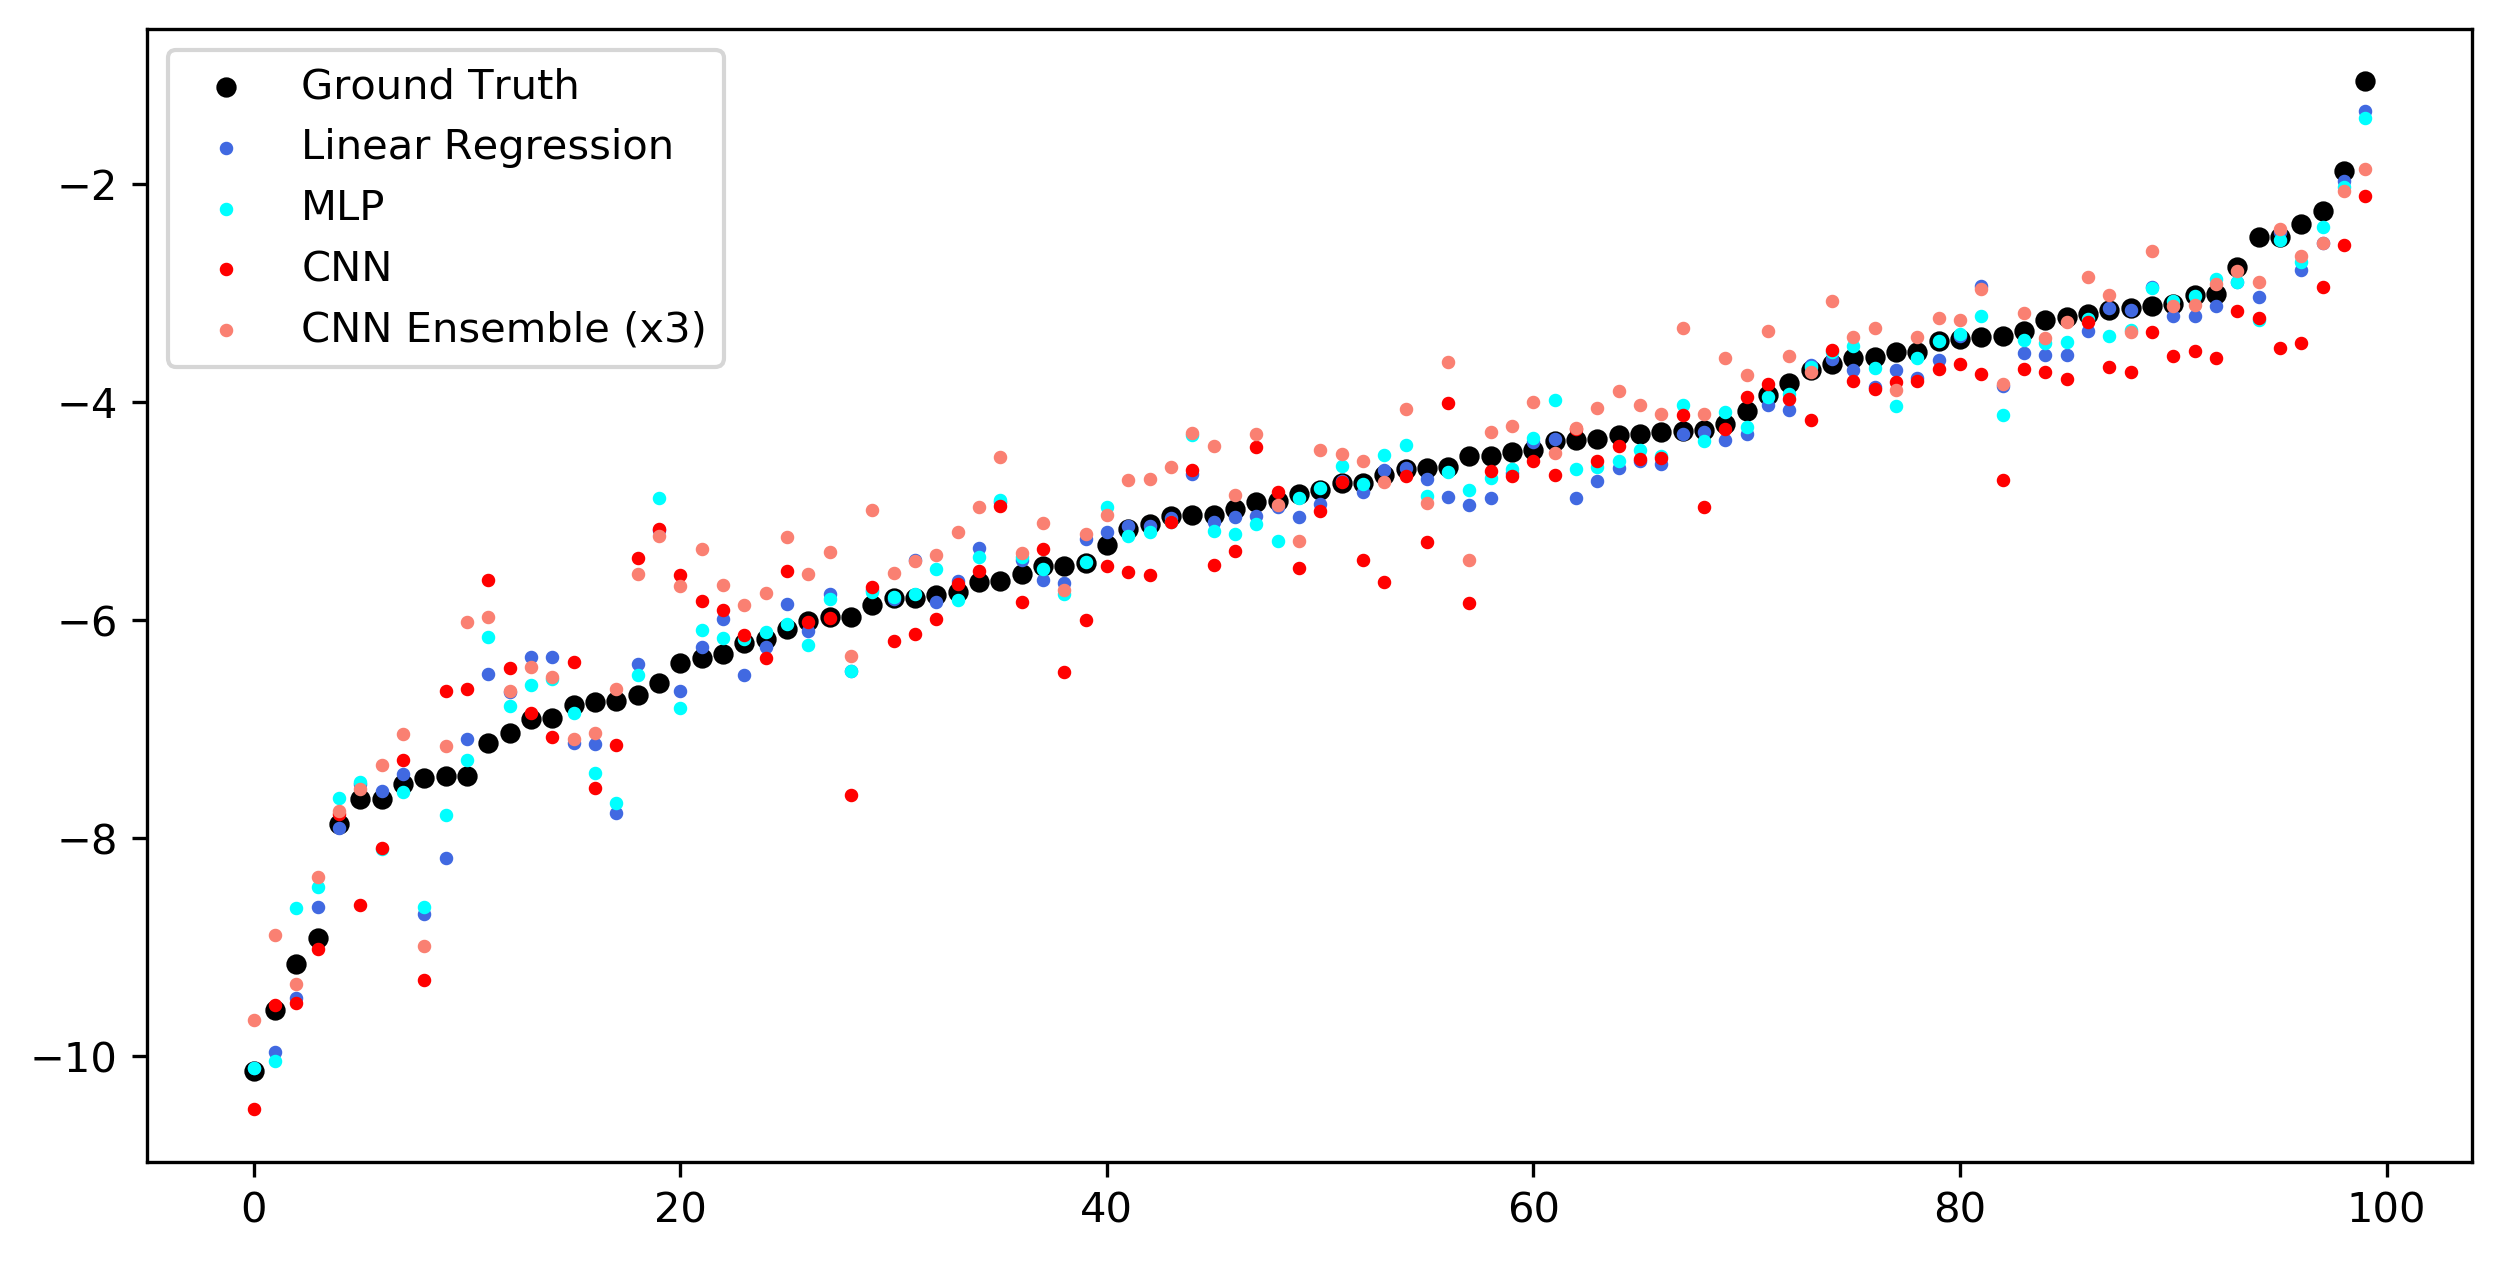

In [47]:
plt.figure(figsize=(10,5), dpi=300)

sort_order = np.argsort(val_y[:100])

plt.scatter(range(len(sort_order)), val_y[sort_order], c="k", s=15, label="Ground Truth")
plt.scatter(range(len(sort_order)), linear_regression_preds[sort_order], c="royalblue", s=5, label="Linear Regression")
plt.scatter(range(len(sort_order)), mlp_preds[sort_order], c="cyan", s=5, label="MLP")
plt.scatter(range(len(sort_order)), cnn_preds[sort_order], c="red", s=5, label="CNN")
plt.scatter(range(len(sort_order)), cnn_ensemble_preds[sort_order], c="salmon", s=5, label="CNN Ensemble (x3)")

plt.legend()
plt.show()

In [50]:
val_y.max(), landscape.get_fitness([wt]).item()

(-0.5923770347191576, -3.4861790541828745)

In [54]:
val_x[np.argmax(val_y)], wt

('MAQAVVVANQLIPINTHLTLKMMRSESVTPVAIIAECIPRLVSMIVNRAVPLGTTLMPDMVKGYAA',
 'MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQVNRAVPLGTTLMPDMVKGYAA')

Now that we have models, we can use them with an exploration algorithm to search the landscape. 

## 3. Exploring the landscape with a model <a class="anchor" id="section-three"></a>

All exploration algorithms in this package inherit from `Base_explorer` which performs some house-keeping tasks. We recommend doing the same when you "bring your own" explorer. It's very easy to implement an explorer in this framework, all it needs to implement is a `propose_sequences` method, that suggest new sequences for which a "costly" measurment to the oracle is performed.  

In [70]:
num_rounds = 5

mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')

random_explorer = baselines.explorers.Random(
    mlp,
    landscape,
    rounds=num_rounds,
    mu=1,
    initial_sequence_data=[wt],
    ground_truth_measurements_per_round=100,
    model_queries_per_round=1000,
    alphabet=s_utils.AAS
)

- `ground_truth_measurements_per_round` denotes the experimental batch size per round
- `model_queries_per_round` is the number of computational queries to the model that is allowed per round. 
- `alphabet` is the alphabet that is permissive on the current landscape.

In [71]:
random_sequences, metadata = random_explorer.run()
random_sequences

round: 0, top: -3.4861790541828745
round: 1, top: -1.7252375660851211
round: 2, top: 0.07410870896320176
round: 3, top: 0.14833389776925898
round: 4, top: 0.4194982600646047
round: 5, top: 1.2824847910064026


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,NaN,-3.486179,0,0,1
0,MAQASVVNNQLIPINTHLTLVMMRSEVTTPVGIPAEDIPRLVSMQV...,-4.031650,-4.702219,1,1001,100
1,MAQASVKANQWIPINTHLTLVRMRWEVVTPVGIPAEDIPRLVSMQV...,-4.048572,-5.485899,1,1001,100
2,MAQASVVANQLIPINTESTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,-4.052542,-11.490700,1,1001,100
3,MAQASVVANQLIPINTHGTLYMMRSEVVTPVGIPAEDQPRLVSMQW...,-4.052969,-6.868012,1,1001,100
...,...,...,...,...,...,...
94,RAGASVVANSLIPINTHLTLVMMRSEVVTPPGIPAEYIPRLVSMQV...,-1.160474,-1.321000,5,5005,496
95,MTQASVVANQLIPENTHLTLVMLRSEVTTPVGIPAESIPRIMDMQV...,-1.161721,-0.102863,5,5005,496
96,MTQASVVANQLIPINTHLKLVMVRSEVVTPIGIPAEDIPRLMDMQV...,-1.162490,-1.656597,5,5005,496
97,RIQASLVANSLIPINTKLYLVMMAPEVVTPPNIPAEFIPRLVSMQV...,-1.172230,-1.906156,5,5005,496


Let's see what was printed:
- The number of **rounds** represents how many experiments was done
- The **cost** shows how many total calls to the oracle was made (experimental cost). Because training the model had an overhead, that is accounted in the total cost. 
- The **evals** shows how many total calls to the model was made (computational cost).
- **Top** simply lists the top fitness (cumulative) observed through the exploration

In [72]:
mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')

adalead_explorer = baselines.explorers.Adalead(
    mlp,
    landscape,
    rounds=num_rounds,
    initial_sequence_data=[wt],
    ground_truth_measurements_per_round=100,
    model_queries_per_round=1000,
    alphabet=s_utils.AAS
)

In [73]:
adalead_sequences, metadata = adalead_explorer.run()
adalead_sequences

round: 0, top: -3.4861790541828754
round: 1, top: -8.977054926325803
round: 2, top: -5.295374431230649
round: 3, top: -9.13102755179033
round: 4, top: -5.095127467852694
round: 5, top: -3.5222120476113843


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,NaN,-3.486179,0,0,1
0,DEYNKCNGNRGGALIWFKPACKTNMYDQEELSTLYGLTELNPAQMQ...,-0.324569,-10.461446,1,1100,100
1,IQLALHWDVSSNTALFAWAELAKNWKVHCATHRRCRHACCQNIKYP...,-0.354722,-18.267390,1,1100,100
2,IQLALHWDVSFNTALFAWAELAKNWKVHCATHRWCRHACCQNIKYP...,-0.356166,-18.221276,1,1100,100
3,DEYNKCNGNRGGALIWFKPACKTNMYDQEELSTLYGLTELNPAKMQ...,-0.381914,-10.638249,1,1100,100
...,...,...,...,...,...,...
94,MARASASPMCPQPINTHLTLVVTAHEVRTPVFLPAEPMCRLQSSQV...,-9.036479,-14.129977,5,5800,496
95,MSPEQGVANQLIPHNTHLTAFAMRTEVSTPCTAPADAIPRLVTYQN...,-9.039617,-8.026555,5,5800,496
96,MARASASPMCPIPINTHLTLVVTASEVRTPVFLPAEPMWRLQSSQV...,-9.048142,-8.321102,5,5800,496
97,MARASASPMCPQPINTHLTLVVTASEVRTPVFLPAEPMCRLQSSQV...,-9.050035,-10.744268,5,5800,496


In [83]:
mlp = baselines.models.MLP(sequence_length, hidden_size=100, alphabet=s_utils.AAS, loss='MSE')

genetic_explorer = baselines.explorers.GeneticAlgorithm(
    mlp,
    landscape,
    
    population_size=40,
    parent_selection_strategy='softmax-sampling',
    softmax_temperature=0.1,
    children_proportion=0.5,
    
    rounds=num_rounds,
    initial_sequence_data=[wt],
    ground_truth_measurements_per_round=100,
    model_queries_per_round=1000,
    alphabet=s_utils.AAS,
    log_file='test_log.csv'
)

In [84]:
genetic_algo_sequences, metadata = genetic_explorer.run()
genetic_algo_sequences

round: 0, top: -3.4861790541828754
round: 1, top: -2.230737806705379
round: 2, top: -0.31134630850678374
round: 3, top: 1.0457460529387166
round: 4, top: 2.4810464310668947
round: 5, top: 3.8090364446856113


,sequence,model_score,true_score,round,model_cost,measurement_cost
0,MAQASVVANQLIPINTHLTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,NaN,-3.486179,0,0,1
0,MAQASVVANQLIPINTHLTRVMMRSEWVPPVGIPAEDIPRLVSMVV...,-3.690484,-6.527288,1,965,100
1,MAQASVVANQLIPINTHLTRVMMRSEWVPPVGIPAEDIPRLVSMVV...,-3.736758,-6.394724,1,965,100
2,MAQASVVANQLIPINTHLTLVMMRSEWVPPVGIPAEDIPRLVSMVV...,-3.851020,-6.675002,1,965,100
3,MAQASVVANQLIPINTHLTLVMMRSEVVKPVGIPAEDIPWLVSMQV...,-3.913681,-4.869393,1,965,100
...,...,...,...,...,...,...
94,KAQASVVLAQLIPDNTHLTLQMMRSEVRTPVGIPGPLIPRLVSMQV...,1.726841,2.886839,5,4823,496
95,KAQASVVLAQLIPDNTHLSLQMMRSEVVTPVGIPGPLIPRLVSMQV...,1.726752,2.397164,5,4823,496
96,KAQASVVLAQLIPDNTHLTLQMMRSEVVTPAGIPGPLIPRLVSMQV...,1.726680,2.710158,5,4823,496
97,KAQASVVLAQLIPDNTHLTLQMLRSEVVTPVGIPGPLIPRLVSMQV...,1.726433,3.230996,5,4823,496


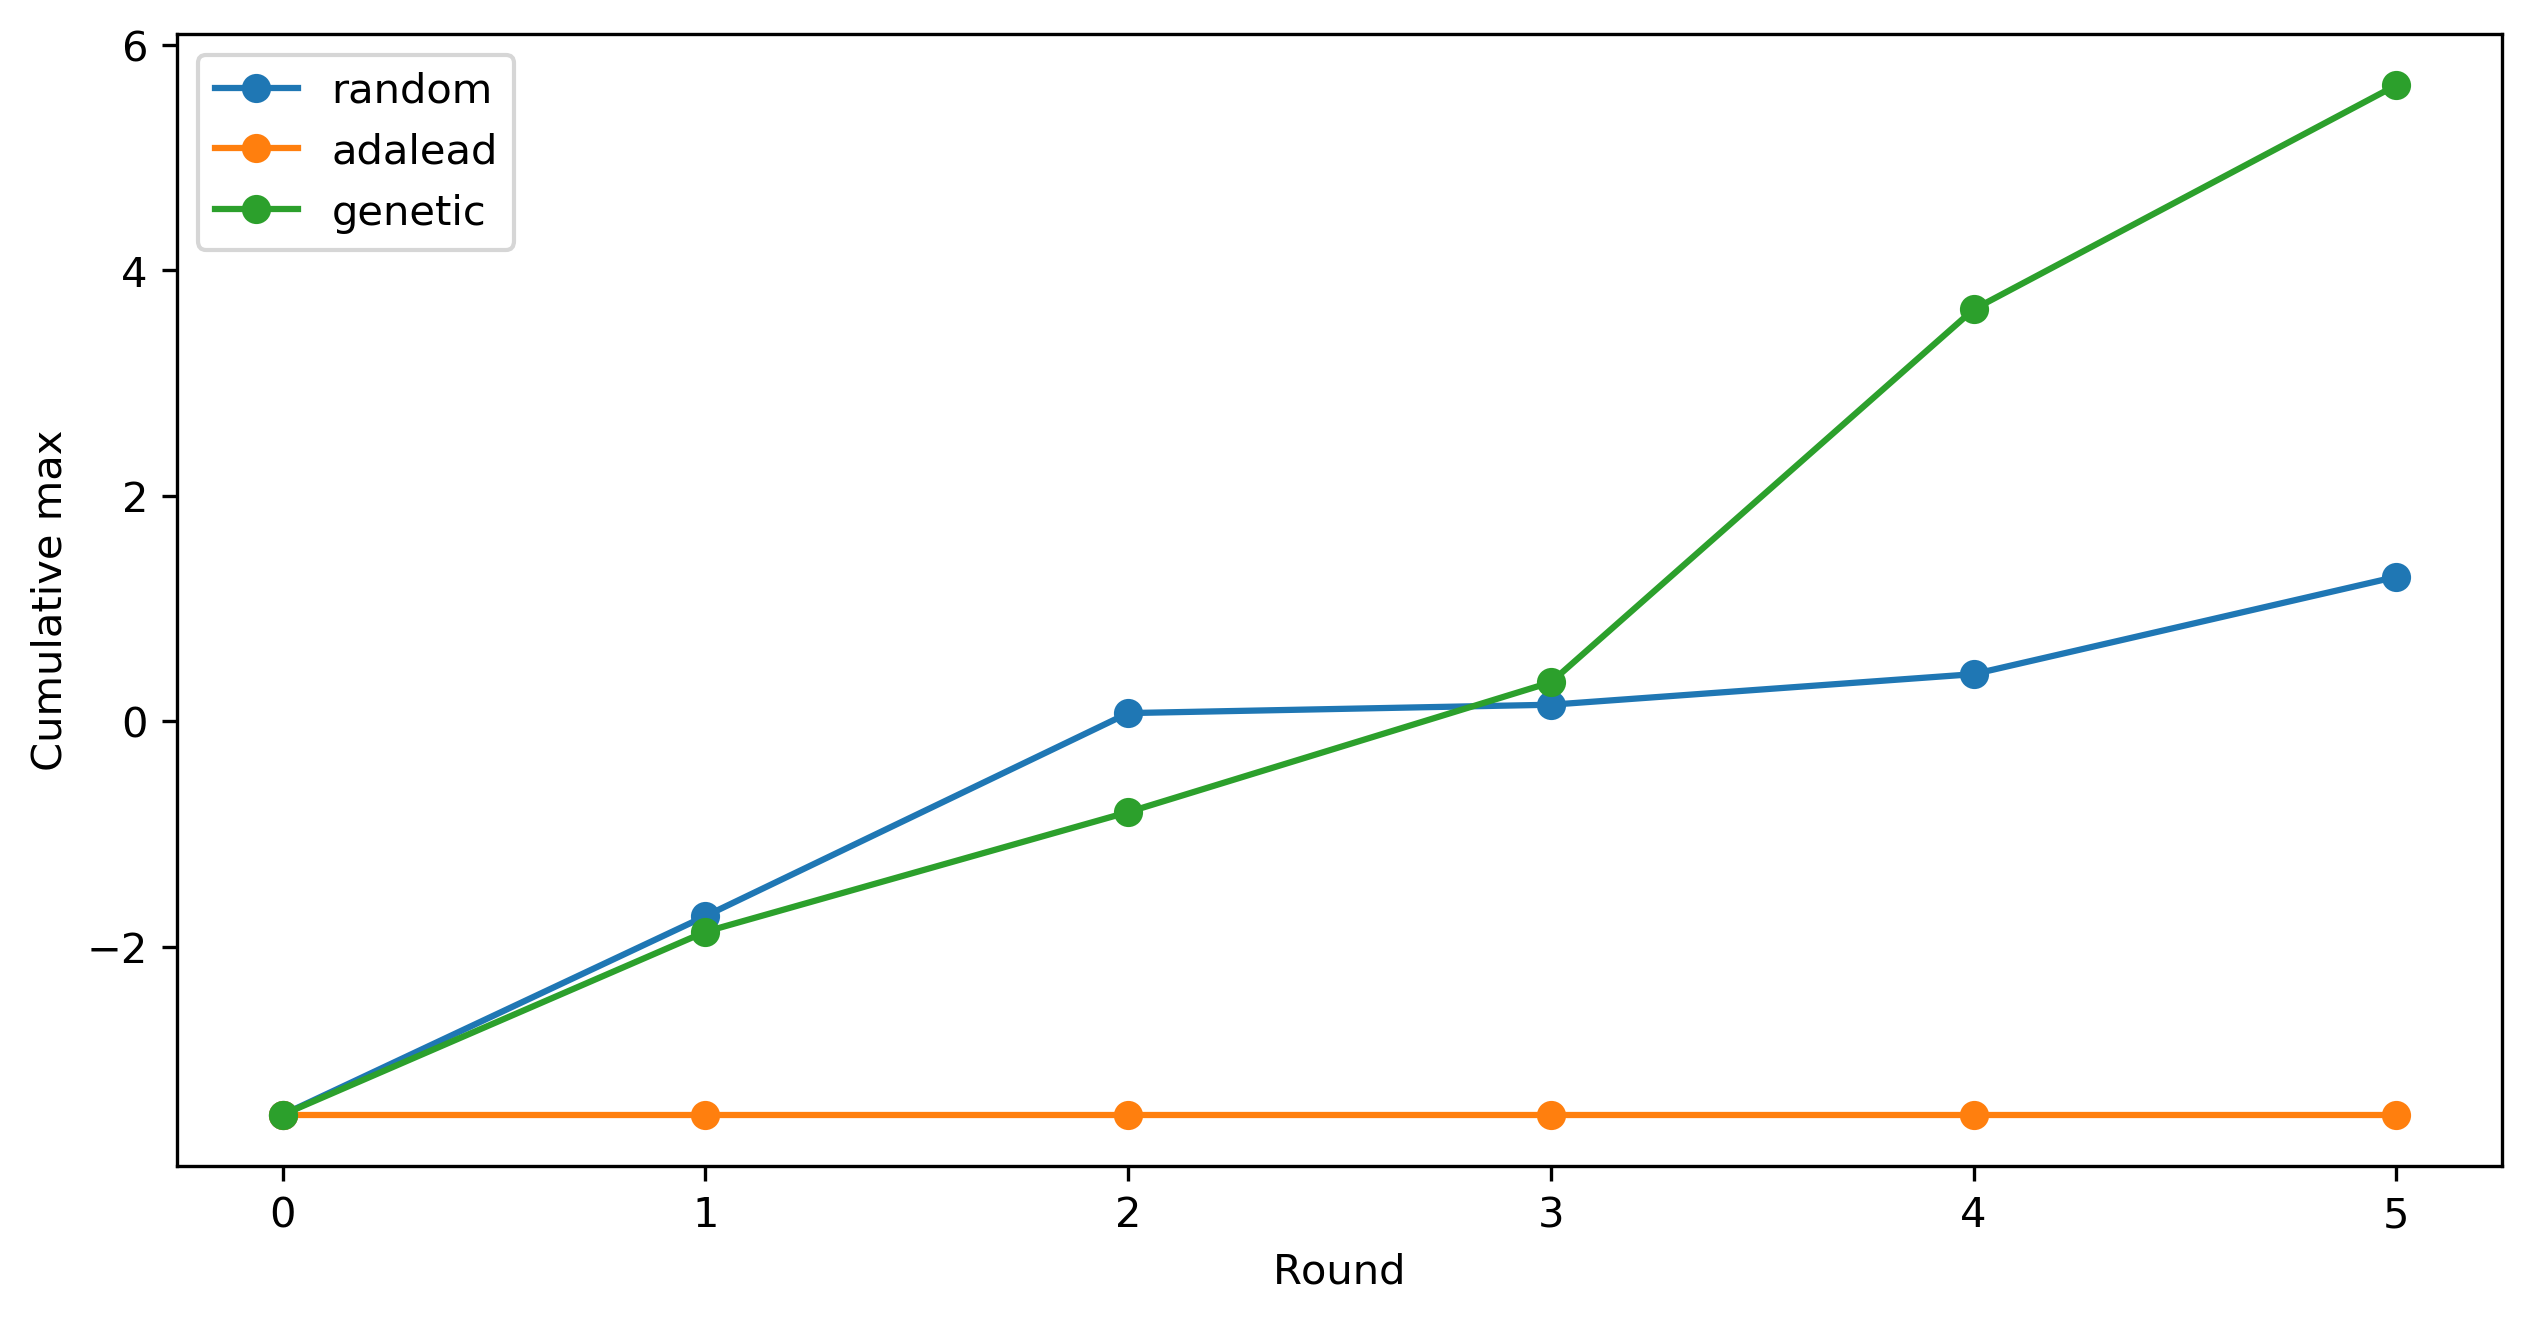

In [77]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]

    return np.maximum.accumulate(max_per_round)

num_rounds = 5

plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(num_rounds + 1), cumulative_max_per_round(random_sequences), 'o-', label="random")
plt.plot(range(num_rounds + 1), cumulative_max_per_round(adalead_sequences), 'o-', label="adalead")
plt.plot(range(num_rounds + 1), cumulative_max_per_round(genetic_algo_sequences), 'o-', label="genetic")
plt.ylabel("Cumulative max")
plt.xlabel("Round")
plt.legend()
plt.show()

## 4. Evaluating an exploration algorithm <a class="anchor" id="section-four"></a>


Pick the landscapes you want to run the evaluation suite on. This can be done by including indexes or "all" which results in loading all pre-defined landscapes. 

**WARNING**: Running evaluators on all landscapes would take forever if not done in a parallel fashion. Debug your process with a couple of landscapes first. We recommend sending each evaluation-landscape pair to a separate worker.  

In [ ]:
# This is old! I am still in the middle of rewriting the evaluation suite,
# so I'm leaving this here for reference

greedy_exp= Greedy(recomb_rate=0.2, threshold=0.05, mu=2, virtual_screen=20)
LANDSCAPE_TYPES ={"RNA": [0],"TF": []}#["GFP": "all","ADDITIVE":"all"]
evaluator=Evaluator(greedy_exp,landscape_types=LANDSCAPE_TYPES, path="../simulations/eval/",ML_ensemble=["GB","Linear","CNNa", "CNNa"])\
                                                                    #path to where the results are saved

The evaluator can run tests aimed at different properties of the explorer. 

The tests include:
- `consistency_robustness_independence`: shows how explorer performance changes given different models.
- `efficiency`: shows how explorer performance changes when more computational evals are allowed
- `adaptivity`: shows how the explorer is sensitive to the number of batches it is allowed to sample
- `scalability`: shows how fast the explorer produces a batch. 

Note that once you run a particular test (among these), if you want to run more tests, you need to re-run `load_landscapes` on the evaluator (as the generator stack is depleted.  

In [ ]:
# This is also old!

evaluator.evaluate_for_landscapes(evaluator.consistency_robustness_independence,\
                                  num_starts=2) #num starts determines how many starting points
                                                #should be tested per landscape

In [53]:
def make_explorer(model):
    return baselines.explorers.Random(
            model,
            landscape,
            rounds=5,
            initial_sequences=[wt],
            mu=mutation_rate,
            ground_truth_measurements_per_round=1000,
            model_queries_per_round=5000,
            alphabet=s_utils.RNAA
        )

flexs.evaluate.robustness(landscape, make_explorer)

Evaluating for signal_strength: 0
round: 1, top: 0.4229142433446849
round: 2, top: 0.5272697400008672
round: 3, top: 0.5217773261422901
round: 4, top: 0.6590871488113138
round: 5, top: 0.6590871488113138
Evaluating for signal_strength: 0.5
round: 1, top: 0.46410719014539203
round: 2, top: 0.5657164798722858
round: 3, top: 0.6151479950813181
round: 4, top: 0.6371175981360863
round: 5, top: 0.7689350069465327
Evaluating for signal_strength: 0.9
round: 1, top: 0.5657164798722858
round: 2, top: 0.590432237476802
round: 3, top: 0.6865491133451186
round: 4, top: 0.724995853216537
round: 5, top: 0.7716812138758213
Evaluating for signal_strength: 1
round: 1, top: 0.6233866158691839
round: 2, top: 0.6343713912067976
round: 3, top: 0.6728181310782162
round: 4, top: 0.7854121961427237
round: 5, top: 0.757950231608919
